In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

#1. Load and normalize CIFAR10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data1', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data1', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
len(testloader)

Files already downloaded and verified
Files already downloaded and verified


2500

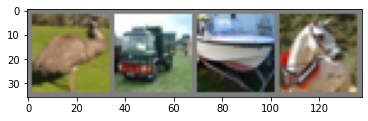

 bird truck  ship horse


In [21]:
#1.1 Let us show some of the training images, for fun

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [22]:
#2. Define a Convolutional Neural Network

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [23]:
#3. Define a Loss function and optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [24]:
#4. Train the network

for epoch in range(2):# loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()


        #print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.001
[1,  4000] loss: 0.001
[1,  6000] loss: 0.001
[1,  8000] loss: 0.001
[1, 10000] loss: 0.000
[1, 12000] loss: 0.000
[2,  2000] loss: 0.001
[2,  4000] loss: 0.001
[2,  6000] loss: 0.001
[2,  8000] loss: 0.000
[2, 10000] loss: 0.000
[2, 12000] loss: 0.001
Finished Training


In [25]:
#save our trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

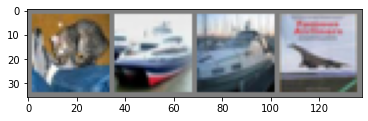

GroundTruth:    cat  ship  ship plane


In [26]:
#5. Test the network on the test data

dataiter = iter(testloader)
images, labels = dataiter.next()

#print image
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [27]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [28]:
outputs = net(images)
_, predicated = torch.max(outputs,1)
print('Predicted: ', ' '.join('%5s' % classes[predicated[j]] for j in range(4)))

Predicted:    dog  ship  ship  ship


In [29]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
         # the class with the highest energy is what we choose as prediction
        _, predicated = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicated == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [30]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 55.5 %
Accuracy for class car   is: 73.5 %
Accuracy for class bird  is: 33.8 %
Accuracy for class cat   is: 25.7 %
Accuracy for class deer  is: 54.0 %
Accuracy for class dog   is: 56.8 %
Accuracy for class frog  is: 67.7 %
Accuracy for class horse is: 68.1 %
Accuracy for class ship  is: 68.9 %
Accuracy for class truck is: 46.2 %


In [32]:
#Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#model to cuda
net.to(device)
#emember that you will have to send the inputs and targets at every step to the GPU too
imputs, labels = data[0].to(device),data[1].to(device)

cuda:0
